In [1]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, precision_score, recall_score, accuracy_score
from PIL import Image


import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.utils import Sequence
import os
from datetime import datetime
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB4
from keras import layers
from keras import models
from keras.models import Model
from tensorflow.keras.layers.experimental import preprocessing

In [2]:
# Define the root directory where your data is stored
root_directory = "dataset_2_final"

# Get the list of subdirectories (categories)
subdirectories = [subdir for subdir in os.listdir(root_directory) if os.path.isdir(os.path.join(root_directory, subdir))]

# Create lists to store image paths and corresponding labels
image_paths = []
labels = []

# Iterate through each subdirectory (category)
for label, subdirectory in enumerate(subdirectories):
    # Construct the full path to the subdirectory
    subdirectory_path = os.path.join(root_directory, subdirectory)

    # Get a list of image files in the subdirectory
    image_files = [os.path.join(subdirectory_path, filename) for filename in os.listdir(subdirectory_path) if filename.endswith('.jpg')]  # Adjust the file extension as needed
    
    # Append image paths and labels
    image_paths.extend(image_files)
    labels.extend([label] * len(image_files))



# Print the number of images and labels
print("Total images:", len(image_paths))
print("Total labels:", len(labels))

Total images: 494
Total labels: 494


In [3]:
# Here we create a custom data generator that inherits from the Sequence class
class CustomDataGenerator(Sequence):
    def __init__(self, image_paths, labels, batch_size, image_size):
        self.image_paths = image_paths
        self.labels = labels
        self.batch_size = batch_size
        self.image_size = image_size
        self.num_samples = 4 * len(image_paths)
        self.indices = np.arange(self.num_samples)


    def __len__(self):        

        # I calculate the number of batches
        return int(np.ceil(self.num_samples / self.batch_size))


    def __getitem__(self, index):

        #This function is called when you call the generator
        batch_indices = self.indices[index * self.batch_size : (index + 1) * self.batch_size]

        batch_images = []
        batch_labels = []

        # Iterate over indices in the current batch
        for batch_index in batch_indices:

            # Calculate the index of the original image and the piece index within it
            image_index = batch_index // 4   # Divide by 4 to get original image index
            piece_index = batch_index % 4    # Modulus 4 to get piece index

            # Get the image path and original label for the current image
            image_path = self.image_paths[image_index]
            original_label = self.labels[image_index]
            image_pieces = self.load_image(image_path)

            # Load and split the image into pieces
            piece = image_pieces[piece_index]
            batch_images.append(piece)
            batch_labels.append(original_label)


        batch_images = np.array(batch_images)
        batch_labels = np.array(batch_labels)

        return batch_images, batch_labels

    def load_image(self, image_path):    

        # Load the original image using Pillow
        original_image = Image.open(image_path)
        original_image_array = np.array(original_image)

        # Split the original image into 4 pieces
        h, w, c = original_image_array.shape
        h_half, w_half = h // 2, w // 2
       
        image_pieces = [
            original_image_array[:h_half, :w_half],
            original_image_array[:h_half, w_half:],
            original_image_array[h_half:, :w_half],
            original_image_array[h_half:, w_half:]
        ]
        
        # Resize the image pieces and provide the shape of the output
        resized_images = [tf.image.resize(piece, self.image_size) for piece in image_pieces]

        #Shape of resized image list
        #print(np.array(resized_images).shape)    
        
        return resized_images


In [4]:

batch_size = 16
image_size = (380, 380)  # Adjust the image size based on your model's input requirements

#Make training and validation sets. The test set, I will handle independently in another file

train_paths, val_paths, train_labels, val_labels = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# Create data generators for training, validation, and test sets
train_generator = CustomDataGenerator(train_paths, train_labels, batch_size, image_size)
val_generator = CustomDataGenerator(val_paths, val_labels, batch_size, image_size)


In [5]:

# Calculate the sizes of the datasets
train_size = len(train_paths)
val_size = len(val_paths)

# Print the sizes
print(f"Training Set Size: {train_size} samples")
print(f"Validation Set Size: {val_size} samples")




Training Set Size: 395 samples
Validation Set Size: 99 samples


In [6]:
model=models.Sequential()


input_shape = (255, 255, 3)

model.add(layers.Rescaling(scale = 1./255, offset=0.0, input_shape=input_shape))

model.add(layers.RandomFlip("horizontal_and_vertical"))
model.add(layers.RandomRotation(0.2))
model.add(layers.RandomZoom(0.2))
model.add(layers.RandomContrast(0.2))
model.add(layers.RandomTranslation(0.2, 0.2)) 


model.add(layers.Conv2D(filters=32, kernel_size=(2,2), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=64, kernel_size=(2,2), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=128, kernel_size=(2,2), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=256, kernel_size=(2,2), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))
model.add(layers.Conv2D(filters=512, kernel_size=(2,2), activation='relu',))
model.add(layers.MaxPooling2D(pool_size=(2, 2)))


# Add flatten layer
model.add(layers.Flatten())

# Add dense/dropout layers + activation functions

model.add(layers.Dense(512, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(256, activation = 'relu'))
model.add(layers.Dropout(0.3))
model.add(layers.Dense(7, activation = 'softmax'))


#optimizer = tf.keras.optimizers.Adam(learning_rate=0.001, clipvalue=0.5)
adam = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08)

model.compile(optimizer = adam, loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
model.summary()

# plot_model(model, to_file='model.png', show_shapes=True,  rankdir='LR')

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
rescaling (Rescaling)        (None, 255, 255, 3)       0         
_________________________________________________________________
random_flip (RandomFlip)     (None, 255, 255, 3)       0         
_________________________________________________________________
random_rotation (RandomRotat (None, 255, 255, 3)       0         
_________________________________________________________________
random_zoom (RandomZoom)     (None, 255, 255, 3)       0         
_________________________________________________________________
random_contrast (RandomContr (None, 255, 255, 3)       0         
_________________________________________________________________
random_translation (RandomTr (None, 255, 255, 3)       0         
_________________________________________________________________
conv2d (Conv2D)              (None, 254, 254, 32)      4

In [7]:
# base_model = EfficientNetB4(include_top = False ,weights='imagenet', pooling='avg')

# # Introduce a layer of data augmentation
# data_augmentation = Sequential([
#     preprocessing.RandomRotation(0.2),
#     preprocessing.RandomFlip("horizontal"),
#     preprocessing.RandomZoom(0.2),
#     preprocessing.RandomContrast(0.2),
#     preprocessing.RandomTranslation(0.2, 0.2),
#     preprocessing.RandomHeight(0.2),
#     preprocessing.RandomWidth(0.2),
# ])

# # Freeze all layers in the base model
# for layer in base_model.layers:
#     layer.trainable = False
# # Unfreeze the last 10 layers in the base model for fine-tuning
# for layer in base_model.layers[-5:]:
#     layer.trainable = True


# #capa de entradas. I think I dont need it
# entradas = layers.Input((380, 380, 3))

# # Capa de augmentation
# x = data_augmentation(entradas)
# # Pass the augmented images through the base model
# x = base_model(x)
# # Add a dense layer
# x = layers.Dense(256, activation='relu')(x)
# # Add another dense layer
# salidas = layers.Dense(7, activation='softmax')(x)


# model = Model(inputs = entradas, outputs = salidas)
# model.compile(optimizer = 'adam', loss = 'sparse_categorical_crossentropy', metrics = ['accuracy'])
# model.summary()


In [8]:
tf.keras.backend.clear_session()

In [ ]:
# Train the model using the custom data generators and the debugging callback
history = model.fit(train_generator, epochs=25, validation_data=val_generator, shuffle=True, callbacks=[])

Epoch 1/25
99/99 [==============================] - 297s 3s/step - loss: 1.9702 - accuracy: 0.2519 - val_loss: 1.9495 - val_accuracy: 0.2121
Epoch 2/25
99/99 [==============================] - 285s 3s/step - loss: 1.9168 - accuracy: 0.2608 - val_loss: 1.9416 - val_accuracy: 0.2121
Epoch 3/25
99/99 [==============================] - 234s 2s/step - loss: 1.9227 - accuracy: 0.2608 - val_loss: 1.9447 - val_accuracy: 0.2121
Epoch 4/25
99/99 [==============================] - 220s 2s/step - loss: 1.9091 - accuracy: 0.2608 - val_loss: 1.9375 - val_accuracy: 0.2121
Epoch 5/25
99/99 [==============================] - 215s 2s/step - loss: 1.9044 - accuracy: 0.2608 - val_loss: 1.9450 - val_accuracy: 0.2121
Epoch 6/25
47/99 [=============>................] - ETA: 1:40 - loss: 1.9039 - accuracy: 0.2447

: 

: 

In [9]:
history
print(history.history.keys())

NameError: name 'history' is not defined

In [10]:
folder_date = 'old_models/' +  datetime.now().strftime("%Y_%m_%d-%I_%M_%S_%p")
os.mkdir(folder_date)
filepath_model = folder_date + '/my_best_model.epoch{epoch:02d}-loss{val_loss:.2f}.hdf5'

In [11]:
#Guardo el modelo en la última epoch
model.save(folder_date + '/modelo_entrenado.h5')

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])


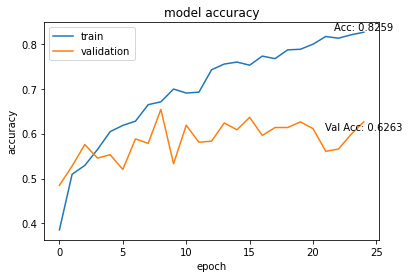

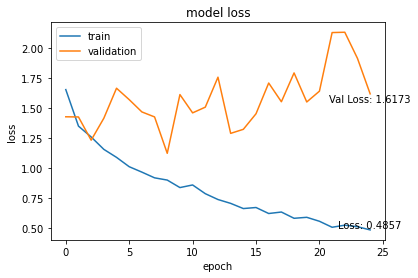

In [ ]:
print(history.history.keys())

#  "Accuracy"
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.text(len(history.history['accuracy'])-1, history.history['accuracy'][-1], 
         f"Acc: {history.history['accuracy'][-1]:.4f}", ha='center', va='bottom')
plt.text(len(history.history['val_accuracy'])-1, history.history['val_accuracy'][-1], 
         f"Val Acc: {history.history['val_accuracy'][-1]:.4f}", ha='center', va='top')


plt.savefig(folder_date + "/accuracy.png")
plt.show()

# "Loss"
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')

plt.text(len(history.history['loss'])-1, history.history['loss'][-1], 
         f"Loss: {history.history['loss'][-1]:.4f}", ha='center', va='bottom')
plt.text(len(history.history['val_loss'])-1, history.history['val_loss'][-1], 
         f"Val Loss: {history.history['val_loss'][-1]:.4f}", ha='center', va='top')


plt.savefig(folder_date + "/loss.png")
plt.show()


[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 3, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 6, 1, 6, 6, 1, 4, 6, 1, 2, 1, 2, 2, 4, 2, 2, 2, 2, 2, 2, 2, 3, 0, 3, 3, 3, 3, 0, 0, 3, 3, 2, 0, 6, 6, 6, 3, 3, 3, 3, 3, 6, 6, 6, 4, 6, 4, 6, 6, 4, 4, 6, 6, 6, 6, 4, 6, 4, 6, 6, 6, 0, 0, 6, 0, 0, 6, 5, 6, 6, 6, 2, 5, 5, 6, 5, 6, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 4, 6, 6, 6, 1, 6, 6, 6]
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6, 6]


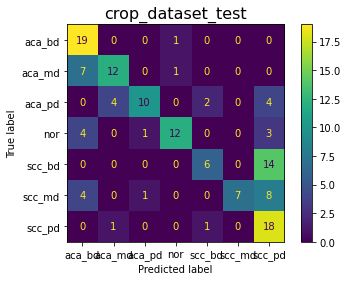

Precision: 0.7149753518428649
Recall: 0.6
Accuracy: 0.6


In [ ]:
# Load the test images from the folder 'test_images'
predicted_labels= []
true_labels = []
directory = "crop_dataset_test"


label_mapping = {
    'aca_bd': 0,
    'aca_md': 1,
    'aca_pd': 2,
    'nor' : 3,
    'scc_bd' : 4,
    'scc_md' : 5, 
    'scc_pd' : 6
}


for filename in os.listdir(directory):

    # Load the image and add it to the list of test images
    f = os.path.join(directory, filename)
    imagen = tf.keras.preprocessing.image.load_img(f, target_size=(380,380))
    x = tf.keras.preprocessing.image.img_to_array(imagen)    
    x = np.expand_dims(x, axis=0)

    prediction = model.predict(x)
    predicted_class = np.argmax(prediction)

    #True labels are calculated based on name. It is a very weak way of doing it. Look for a better one or rename the files

    if 'aca_bd' in filename:
        true_labels.append(0)
    elif 'aca_md' in filename:
        true_labels.append(1)
    elif 'aca_pd' in filename:
        true_labels.append(2)
    elif 'nor' in filename:
        true_labels.append(3)
    elif 'scc_bd' in filename:
        true_labels.append(4)    
    elif 'scc_md' in filename:
        true_labels.append(5)
    elif 'scc_pd' in filename:
        true_labels.append(6)
    
    predicted_labels.append(predicted_class)

print(predicted_labels)
print(true_labels)


cm = confusion_matrix(true_labels, predicted_labels)
labels = [label for label, _ in sorted(label_mapping.items(), key=lambda x: x[1])]
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
disp.plot()

plt.title(directory,  fontdict={'fontsize': 16})  # Set the new title for the plot
plt.show()


# Calculate precision, recall, and accuracy
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
accuracy = accuracy_score(true_labels, predicted_labels)

# Print the results
print("Precision:", precision)
print("Recall:", recall)
print("Accuracy:", accuracy)
